# Unconditional Diffusion Model

This Notebook concerns the diffusion model class itself.

1. Theory:
    - Forward trajectory
    - Reverse trajectory
    - Training
    - Training Algorithm
    - Sampling Algorithm
2. Initialization Arguments for our Diffusion Model
3. Parameters of our Diffusion Model
4. Code for the Class of our Unconditional Diffusion Model
5. Visualizing the Diffusion Model:
    - Applying Forward and Reverse Trajectories
    - Visual Comparison between Noise schedulers
    - Analytical Comparison between Noise schedulers
    - Visualizing the loss MSE weights from the VLB

## Theory

<u>**Forward trajectory:**</u> <br/>
 <br/>
The diffusion model specifies a Markov Chain with random variables $$x_0\rightarrow x_1\rightarrow...\rightarrow x_T.$$ 
$x_0$ denotes an image from our dataset, while the remaining $x_t$ are latents resulting from adding Gaussian noise to $x_0$ $t$ times.<br/>
We add noise along the chain by iteratively drawing from the noise distributions <br/> 
<br/>
$$q(x_t | x_{t-1}) :=  \mathcal{N}(x_t | \sqrt{1-\beta_t}x_{t-1}, \beta_t I),\ \text{ where } \beta_t \in (0,1) \ \text{and} \ \beta_1 < ... < \beta_T.$$
<br/>
Since these noise dist. are uncorrelated, they can be combined into a single Gaussian noise dist. that allows us to add noise $t$ times by drawing from it only once, 
<br/>
$$q(x_t | x_0) = \mathcal{N}(x_t | \sqrt{\bar{\alpha}_t}x_0 , (1-\bar{\alpha}_t)I), \quad \text{where} \ \ \alpha_t = (1-\beta_t) \ \text{and} \ \bar{\alpha}_t :=  \prod_{i=1}^{t}\alpha_i \quad \text{for} \ t \in \{1,...,T\}.$$
These fixed and not learned hyperparameters $\beta_t, \alpha_t$ and $\bar{\alpha}_t$ determine the quantity and rate at which we add noise along the chain. <br/>
When drawing from these dist. $x_t \sim q(x_t | x_0)$  we apply the reparametrization trick, i.e.<br/>
<br/>
$$ x_t= \sqrt{\bar{\alpha}_t} x_{0} + \sqrt{1 -\bar{\alpha}_t} \epsilon, \quad \text{ where } \epsilon \sim \mathcal{N}(0,I) \tag{1}$$

We refer to the $\epsilon$ in the forward trajectory as the **forward_noise**. For a given image x_0 , this **forward_noise** parameter remains the same for all timesteps $t$ when adding noise and is a crucial part in the coming learning process. It also allows us to avoid storing all noised images along the chain $x_t$, since they can be recomputed through the reparametrization above where $\epsilon =\textbf{forward_noise}$.
<br/> <br/>

<u>**Reverse trajectory:**</u> <br/>
 <br/>
The diffusion model learns to reverse this Markov chain, starting at the noised latent $x_T$
$$x_0\leftarrow x_1\leftarrow...\leftarrow x_T.$$ 
We remove noise along the chain by iteratively drawing from the denoising distributions<br/>
<br/>
$$p_{\theta}(x_{t-1}| x_t) = \mathcal{N}(x_{t-1}|  \mu_{\theta}(x_t,t), \text{var}_t I).$$
<br/>
The variances $\text{var}_t\in (0,1)$ are again not learned and fixed. The means $\mu_{\theta}$ are learned and have the form<br/>
<br/>
\begin{split}
\mu_{\theta}(x_t,t) = &\ \textbf{mean_scaler} \ \biggl( x_t - \ \textbf{noise_scaler} \ \epsilon_{\theta}(x_t, t) \biggr)\\
=&  \quad \quad \quad \frac{1}{\sqrt{\alpha_t}} \left( x_t - \quad \ \frac{1-\alpha_t}{\sqrt{1 - \bar{\alpha}_t}}\epsilon_{\theta}(x_t, t) \right),
\end{split}
<br/>
where a U-Net parametrized by $\theta$ computes $\epsilon_{\theta}(x_t, t)$. We refer to the paper "Denoising Diffusion Probabilistic Models" by Ho et al. for further details. We again apply the reparametrization trick when drawing from these dist. $x_{t-1} \sim p_{\theta}(x_{t-1}| x_t)$<br/>
<br/>
$$ x_{t-1}= \mu_{\theta}(x_t,t) + \sqrt{\text{var}_t} \delta, \quad \text{ where } \delta \sim \mathcal{N}(0,I),$$
<br/>
and the noise parameter $\delta$ simply referred to as **noise** changes for every timestep in order to iteratively draw denoised images along the reverse chain. When generating/sampling new images, we start with an image of pure noise $x_T\sim p_{\theta}(x_T) = \mathcal{N}(0,I)$, and pass it through the complete reverse chain until we draw from $x_{0} \sim p_{\theta}(x_{0}| x_1)$.
<br/> <br/>

<u>**Training:**</u> <br/>
<br/>
As a likelihood model, the learning objective of the DM is derived via a variational lower bound (VLB) defined as
<br/>
<br/>
\begin{split}
  L_{VLB} := L_{T-1} + ... + L_{0}, \quad \text{ where } \
    & L_0 := - \log p_{\theta}(x_0|x_1) \quad \text{and}\\
    & L_{t} := \frac{\beta_t^2}{2\text{var}_t \alpha_t(1-\bar{\alpha}_t)} \big{\|} \epsilon - \epsilon_{\theta}(x_t, t) \big{\|}_{2}^2 \quad \text{ for } t \in \{1, ..., T-1\}.
\end{split}
<br/>
$L_0$ denotes the reconstruction loss and is given by the neg. log prob. of the input image w.r.t our last denoising dist, while the remaining loss terms $L_t$ (originally KL divergences) are a weighted MSE between the **forward_noise** $\epsilon$ and our predicted noise $\epsilon_{\theta}(x_t, t)$ from the U-Net. For this reason, we refer to $\epsilon_{\theta}(x_t, t)$ as the **pred_noise**. In practice, the weight outside of the MSE, in the code refered to as **mse_weight**, is often omitted and called the simplified version.<br/>
If one looks closely at the **mse_weight**, it becomes apparent that for $t$ near $0$, where $\beta_t$ is close to $0$, the weights are very small, while for increasing $t$'s, it steadily grows higher. In the limit where $\beta_T=1$, the weights ultimately diverge to infinity. Therefore, during training, it considers the first denoising steps $t$ near T much more important than the last ones near $0$. Removing the **mse_weight** equally weights all denoising timestep losses $L_t$ and acts as a from of regularization. See visualizations below for our analysis on the mse weights!
<br/>
 
<u>**Training Algorithm**</u>
1. Repeat:
   - Draw a batch of images $\mathbf{x}_0 \sim q(\mathbf{x}_0)$
   - Draw a batch **forward_noise** elements $\mathbf{\epsilon} \sim \mathcal{N}(\mathbf{0},\mathbf{I})$ to add noise on the batch for any timestep $t$
   - Draw a batch of timesteps  $t \sim \text{Uniform}(\{1,...,T\})$ for evey image $x_0$
   - Take gradient descent step on: 
$$\nabla_{\theta} \| \mathbf{\epsilon} - \mathbf{\epsilon}_{\theta}(\sqrt{\bar{\alpha}_t}\mathbf{x}_0 + \sqrt{1 - \bar{\alpha}_t}\mathbf{\epsilon}, t)\|^2$$
2. Until converged <br/>
<br/>
If we want to include the reconstruction loss, we then uniformly draw the batch of timesteps from $t \sim \text{Uniform}(\{0,...,T\})$ and take the gradient descent step on $\nabla_{\theta} L_0$ if $t=0$. Observe that in the gradient descent step, $x_t$ has been reparametrized in terms of the $\textbf{forward_noise}$ as in equation $(1)$.<br/>
<br/>

<u>**Sampling Algorithm**</u>
1. Draw a batch of random noise images $\mathbf{x}_T \sim \mathcal{N}(0,I)$
2. For $t = T, ..., 1$ do:<br/>
    - Sample $\mathbf{z} \sim \mathcal{N}(\mathbf{0},\mathbf{I})$ if $t > 1$, else $\mathbf{z} = 0$ <br/>
    - Update $\mathbf{x}_{t-1} = \frac{1}{\sqrt{\alpha_t}} \left( \mathbf{x}_t - \frac{1 - \alpha_t}{\sqrt{1- \bar{\alpha}_t}} \epsilon_{\theta}(\mathbf{x}_t, t)\right) + \sqrt{\beta_t} \mathbf{z}$
3. return generated batch $\mathbf{x}_0$

The presented theory are adaptations from "Denoising Diffusion Probabilistic Models" by Ho et al. *https://proceedings.neurips.cc/paper/2020/hash/4c5bcfec8584af0d967f1ab10179ca4b-Abstract.html*

## Initialization Arguments for our Diffusion Model

| DDPM init arguments | description | 
| --- | --- | 
| net | U-Net to predict noise on the currnet noised latent |
| diffusion_steps | Length of the Markov chain T|
| out_shape | Shape of the models output images |
| noise_schedule | Methods of initialization for the noise dist. variances; 'linear', 'cosine' or 'bounded_cosine' |
| beta_1, beta_T | Variances for the first and last noise dist. (only for the 'linear' noise schedule) |
| alpha_bar_lower_bound | Upper bound for the varaince of the total noise dist. (only for the 'cosine_bounded' noise schedule) |
| var_schedule | Methods of initialization for the denoising dist. variances; 'same' or 'true'|
| kl_loss | Choose between the mathematically correct 'weighted' or most commonly used 'simplified' KL loss |
| recon_loss | 'none' to ignore the reconstruction loss, 'nll' to compute the negative log lekelihood|

**Noise Schedule**:<br/>
Determines how the noise distribution hyperparameters $\beta_t$, $\alpha_t$, and $\bar{\alpha}_t$ are initialized.

+ **linear**:<br/>
Set the noise distribution variances $\beta$ to be linearly scaled between the given bounds:
$$\beta_1 = \textbf{beta_1} \ \text{and} \ \beta_T =\textbf{beta_T} \quad  \text{or}  \quad \beta_1=1e-4 \ \text{and} \ \beta_T = 0.02 \ \ \text{(by default).}$$ 
The $\alpha$ and $\bar{\alpha}$ are computed accordingly.

+ **cosine**:<br/>
From "Improved Denoising Diffusion Probabilistic Models" by Nichol and Dhariwal. Sets the $\bar{\alpha}$'s for a more gradual noise addition to the input image. See results in the cells below.
    $$\bar{\alpha}_t = \frac{f(t)}{f(0)} \quad \text{where} \quad f(t) := \cos \left( \frac{t/T + s}{1+s}  \cdot  \frac{\pi}{2}\right)^{2} \text{ and} \quad \beta_t = 1 - \frac{\bar{\alpha}_t}{\bar{\alpha}_{t-1}} \quad \text{for } t \in \{1,...,T\}$$
    This will always result in 
    $$\bar{\alpha}_1 = 1 \ \text{and} \  \bar{\alpha}_T=0, \quad \text{i.e.} \  \beta_1=0 \  \text{and} \ \beta_T =1.$$

+ **bounded cosine**:<br/>
Our experimental version of a bounded cosine schedule. It still has a linear drop-off in $\bar{\alpha}$ while imposing a lower bound 
$$\bar{\alpha}_T = \textbf{alpha_bar_lower_bound},$$ 
such that we avoid reaching high variances that add too much noise. This is achieved by first computing the cosine schedule $\bar{\alpha}$ and applying min-max normalization to bound it. Later, $\beta$ and $\alpha$ are recomputed from these bounded $\bar{\alpha}$.

**Variance Schedule**:<br/>
Determines how the denoising distribution variances $\text{var}_t$ are initialized.

+ **same**:<br/>
Noise and denoising distributions share the same variances, i.e.,
$$\text{var}_t = \beta_t.$$

+ **true**:<br/>
They are set to the closed-form solution denoising distribution variance $q(x_{t-1} | x_t, x_0)$, i.e.,
$$\text{var}_t = \frac{1-\bar{\alpha}_{t-1}}{1 - \bar{\alpha}_t} \beta_{t}.$$
For more details on this closed-form solution denoising distribution, we refer to the DDPM paper by Ho et al.

**Kl loss**:<br/>
+ **weighted**: <br/>
Include the weight as part of the Kl loss terms:
$$L_t = \frac{\beta_t^2}{2\text{var}_t \alpha_t(1-\bar{\alpha}_t)} \|\epsilon - \epsilon_{\theta}(x_t, t)\|_2^2$$

+ **simplified**: <br/>
Exclude the weight as part of the Kl loss terms:
$$L_t = \|\epsilon - \epsilon_{\theta}(x_t, t)\|_2^2$$

**Reconstruction Loss**:<br/>
+ **none**: <br/>
Ignore the reconstruction loss term $L_0$ as part of the VLB for training.

+ **nll**:<br/>
Include the reconstruction loss term $L_0$ as part of the VLB for training.

The presented diffusion model type optimizations are from "Improved Denoising Diffusion Probabilistic Models" by Nichol and Dhariwal *https://proceedings.mlr.press/v139/nichol21a.html*

## Parameters of our Diffusion Model

| DDPM class parameters | description | 
| --- | --- | 
| net | U-Net to predict noise on the currnet noised latent |
| diffusion_steps | Length of the Markov chain T|
| out_shape | Shape of the models output images |
|beta| noise dist. hyperparam |
|alpha| noise dist. hyperparam |
|alpha_bar| noise dist. hyperparam |
|var| varaince of the denoising dist.|
|std| standatrd deviation of the denoising dist.|
| noise_schedule | Methods of initialization for the noise dist. variances; 'linear', 'cosine' or 'bounded_cosine' |
| var_schedule | Methods of initialization for the denoising dist. variances; 'same' or 'true'|
|kl_loss | 'weighted' or 'simplified' KL loss |
|recon_loss | 'none' or 'nll' reconstrcution loss|
|sqrt_1_minus_alpha_bar| precomputed for for efficiency reasons|
|sqrt_alpha_bar| precomputed for for efficiency reasons|
|noise_scaler|to compute the mean of the dneoising dist., stored for efficiency reasons|
|mean_scaler| to compute the mean of the dneoising dist., stored for efficiency reasons|
|mse_weight| weight for the $L_t$ loss terms, stored for efficiency reasons|

# Class for the Unconditional Diffusion Model

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import math

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [6]:
class DDPM(nn.Module):
    
    def __init__(self,
                 net=None,
                 diffusion_steps = 50, 
                 out_shape = (3,32,32), 
                 noise_schedule = 'linear', 
                 beta_1 = 1e-4, 
                 beta_T = 0.02,
                 alpha_bar_lower_bound = 0.9,
                 var_schedule = 'same', 
                 kl_loss = 'simplified', 
                 recon_loss = 'none',
                 device=None):
        '''
        net:                   U-Net
        diffusion_steps:       Length of the Markov chain
        out_shape:             Shape of the models's in- and output images
        noise_schedule:        Methods of initialization for the noise dist. variances, 'linear', 'cosine' or bounded_cosine
        beta_1, beta_T:        Variances for the first and last noise dist. (only for the 'linear' noise schedule)
        alpha_bar_lower_bound: Upper bound for the varaince of the complete noise dist. (only for the 'cosine_bounded' noise schedule)
        var_schedule:          Options to initialize or learn the denoising dist. variances, 'same', 'true'
        kl_loss:               Choice between the mathematically correct 'weighted' or in practice most commonly used 'simplified' KL loss
        recon_loss:            Is 'none' to ignore the reconstruction loss or 'nll' to compute the negative log likelihood
        '''
        super(DDPM,self).__init__()
        self.device = device
        
        # initialize the beta's, alpha's and alpha_bar's for the given noise schedule
        if noise_schedule == 'linear':
            beta, alpha, alpha_bar = self.linear_schedule(diffusion_steps, beta_1, beta_T, device=self.device)
        elif noise_schedule == 'cosine':
            beta, alpha, alpha_bar = self.cosine_schedule(diffusion_steps, device=self.device)
        elif noise_schedule == 'cosine_bounded':
            beta, alpha, alpha_bar = self.bounded_cosine_schedule(diffusion_steps, alpha_bar_lower_bound, device=self.device)
        else:
            raise ValueError('Unimplemented noise scheduler')
            
        # initialize the denoising varainces for the given varaince schedule 
        if var_schedule == 'same':
            var = beta
        elif var_schedule == 'true':
            var = [beta[0]] + [((1-alpha_bar[t-1])/(1-alpha_bar[t]))*beta[t] for t in range (1,diffusion_steps)]
            var = torch.tensor(var, device=self.device)
        else:
            raise ValueError('Unimplemented variance scheduler')
        
        # check for invalid kl_loss argument
        if (kl_loss != 'simplified') & (kl_loss != 'weighted'): 
            raise ValueError("Unimplemented loss function")
        
        self.net = net
        self.diffusion_steps = diffusion_steps
        self.noise_schedule = noise_schedule
        self.var_schedule = var_schedule
        self.beta = beta
        self.alpha = alpha
        self.alpha_bar = alpha_bar
        self.sqrt_1_minus_alpha_bar = torch.sqrt(1-alpha_bar) # for forward std
        self.sqrt_alpha_bar = torch.sqrt(alpha_bar) # for forward mean
        self.var = var
        self.std = torch.sqrt(self.var)
        self.kl_loss = kl_loss 
        self.recon_loss = recon_loss 
        self.out_shape = out_shape
        # precomputed for efficiency reasons
        self.noise_scaler = (1-alpha)/( self.sqrt_1_minus_alpha_bar)
        self.mean_scaler = 1/torch.sqrt(self.alpha)
        self.mse_weight = (self.beta**2)/(2*self.var*self.alpha*(1-self.alpha_bar))
          
    @staticmethod
    def linear_schedule(diffusion_steps, beta_1, beta_T, device):
        ''''
        Function that returns the noise distribution hyperparameters for the linear schedule.  

        Parameters:
        diffusion_steps (int): Length of the Markov chain.
        beta_1        (float): Variance of the first noise distribution.
        beta_T        (float): Variance of the last noise distribution.
        
        Returns:
        beta      (tensor): Linearly scaled from beta[0] = beta_1 to beta[-1] = beta_T, length is diffusion_steps.
        alpha     (tensor): Length is diffusion_steps.
        alpha_bar (tensor): Length is diffusion_steps.
        '''
        beta = torch.linspace(beta_1, beta_T, diffusion_steps,device=device)
        alpha = 1 - beta
        alpha_bar = torch.cumprod(alpha, dim=0)
        return beta, alpha, alpha_bar
    
    @staticmethod    
    def cosine_schedule(diffusion_steps, device):
        '''
        Function that returns the noise distribution hyperparameters for the cosine schedule.
        From "Improved Denoising Diffusion Probabilistic Models" by Nichol and Dhariwal.

        Parameters:
        diffusion_steps (int): Length of the Markov chain.
        
        Returns:
        beta      (tensor): Length is diffusion_steps.
        alpha     (tensor): Length is diffusion_steps.
        alpha_bar (tensor): Follows a sigmoid-like curve with a linear drop-off in the middle. 
                            Length is diffusion_steps.
        '''
        cosine_0 = DDPM.cosine(torch.tensor(0, device=device), diffusion_steps= diffusion_steps)
        alpha_bar = [DDPM.cosine(torch.tensor(t, device=device),diffusion_steps = diffusion_steps)/cosine_0 
                     for t in range(1, diffusion_steps+1)]
        shift = [1] + alpha_bar[:-1]
        beta = 1 - torch.div(torch.tensor(alpha_bar, device=device), torch.tensor(shift, device=device))
        beta = torch.clamp(beta, min =0, max = 0.999).to(device) #suggested by paper
        alpha = 1 - beta
        alpha_bar = torch.tensor(alpha_bar,device=device)
        return beta, alpha, alpha_bar
    
    @staticmethod    
    def bounded_cosine_schedule(diffusion_steps, alpha_bar_lower_bound, device):
        '''
        Function that returns the noise distribution hyperparameters for our experimental version of a 
        bounded cosine schedule. Benefits are still unproven. It still has a linear drop-off in alpha_bar, 
        but it's not sigmoidal and the betas are no longer smooth.

        Parameters:
        diffusion_steps (int): Length of the Markov chain
        
        Returns:
        beta      (tensor): Length is diffusion_steps
        alpha     (tensor): Length is diffusion_steps
        alpha_bar (tensor): Bounded between (alpha_bar_lower_bound, 1) with a linear drop-off in the middle. 
                            Length is diffusion_steps
        '''
        # get cosine alpha_bar (that range from 1 to 0)
        _, _, alpha_bar = DDPM.cosine_schedule(diffusion_steps, device)
        # apply min max normalization on alpha_bar (range from lower_bound to 0.999)
        min_val = torch.min(alpha_bar)
        max_val = torch.max(alpha_bar)
        alpha_bar = (alpha_bar - min_val) / (max_val - min_val)
        alpha_bar = alpha_bar * (0.9999 - alpha_bar_lower_bound) + alpha_bar_lower_bound # for 0.9999=>beta_1 = 1e-4
        # recompute beta, alpha and alpha_bar
        alpha_bar = alpha_bar.tolist()
        shift = [1] + alpha_bar[:-1]
        beta = 1 - torch.div(torch.tensor(alpha_bar, device = device), torch.tensor(shift, device=device))
        beta = torch.clamp(beta, min=0, max = 0.999)
        beta = torch.tensor(sorted(beta), device = device)
        alpha = 1 - beta
        alpha_bar = torch.cumprod(alpha, dim=0)
        return beta, alpha, alpha_bar

    @staticmethod
    def cosine(t, diffusion_steps, s = 0.008):
        '''
        Helper function that computes the cosine function from "Improved Denoising Diffusion Probabilistic Models" 
        by Nichol and Dhariwal, used for the cosine noise schedules.

        Parameters:
        t               (int): Current timestep
        diffusion_steps (int): Length of the Markov chain
        s             (float): Offset value suggested by the paper. Should be chosen such that sqrt(beta[0]) ~ 1/127.5 
                               (for small T=50, this is not possible)
                                
        Returns:
        (numpy.float64): Value of the cosine function at timestep t
        '''
        return (torch.cos((((t/diffusion_steps)+s)*math.pi)/((1+s)*2)))**2
    
    
    ####
    # Important to note: Timesteps are adjusted to the range t in [1, diffusion_steps] akin to the paper 
    # equations, where x_0 denotes the input image and x_t the noised latent after adding noise t times.
    # Both trajectories work on batches assuming shape=(batch_size, channels, height, width).
    ####
    
    # Forward Trajectory Functions:
    
    @torch.no_grad()
    def forward_trajectory(self, x_0, t = None):
        '''
        Applies noise t times to each input image in the batch x_0.
        
        Parameters:
        x_0 (tensor): Batch of input images, with color channels assumed to be normalized between [-1,1]
        t   (tensor): Batch of timesteps, by default goes through full forward trajectory
    
        Returns:
        x_T           (tensor): Batch of noised images at timestep t
        forward_noise (tensor): Batch of noise parameters from the noise distribution reparametrization used to draw x_T
        '''
        if t is None:
            t = torch.full((x_0.shape[0],), self.diffusion_steps, device = self.device)
        elif torch.any(t == 0):
            raise ValueError("The tensor 't' contains a timestep zero.")
        forward_noise = torch.randn(x_0.shape, device = self.device)
        x_T = self.noised_latent(forward_noise, x_0, t) 
        return x_T , forward_noise
    
    @torch.no_grad()
    def noised_latent(self, forward_noise, x_0, t):
        '''
        Given a batch of noise parameters, this function recomputes the batch of noised images at their respective timesteps t.
        This allows us to avoid storing all the intermediate latents x_t along the forward trajectory.
        
        Parameters:
        forward_noise (tensor): Batch of noise parameters from the noise distribution reparametrization used to draw x_t
        x_0           (tensor): Batch of input images, with color channels assumed to be normalized between [-1,1]
        t             (tensor): Batch of timesteps
    
        Returns:
        x_t           (tensor): Batch of noised images at timestep t
        '''
        mean, std = self.forward_dist_param(x_0, t)
        x_t = mean + std*forward_noise
        return x_t
    
    @torch.no_grad()
    def forward_dist_param(self, x_0, t):
        '''
        Computes the parameters of the complete noise distribution.
        
        Parameters:
        x_0  (tensor): Batch of input images, with color channels assumed to be normalized between [-1,1]
        t    (tensor): Batch of timesteps
    
        Returns:
        mean (tensor): Batch of means for the complete noise distribution for each image in the batch x_0
        std  (tensor): Batch of std scalars for the complete noise distribution for each image in the batch x_0
        '''
        mean = self.sqrt_alpha_bar[t-1][:,None,None,None]*x_0
        std = self.sqrt_1_minus_alpha_bar[t-1][:,None,None,None]
        return mean, std
    
    @torch.no_grad()
    def single_forward_dist_param(self, x_t_1, t):
        '''
        Computes the parameters of the individual noise distribution.

        Parameters:
        x_t_1 (tensor): Batch of noised images at timestep t-1
        t     (tensor): Batch of timesteps
        
        Returns:
        mean (tensor): Batch of means for the individual noise distribution for each image in the batch x_t_1
        std  (tensor): Batch of std scalars for the individual noise distribution for each image in the batch x_t_1
        '''
        mean = torch.sqrt(1-self.beta[t-1])[:,None,None,None]*x_t_1
        std = torch.sqrt(self.beta[t-1])[:,None,None,None]
        return mean, std


    # Reverse Trajectory Functions:

    def reverse_trajectory(self, x_t, t):
        '''
        Draws a denoised images x_{t-1} by reparametrizing the denoising distribution at times t for the current noised
        latents x_t.

        Parameters:
        x_t (tensor): Batch of input images, with color channels assumed to be normalized between [-1,1]
        t   (tensor): Batch of timestep
        
        Returns:
        x_t_1 (tensor): Batch of denoised images at timestep t-1
        '''
        noise = torch.randn(x_t.shape, device=self.device)
        mean, std , _ = self.forward(x_t, t)
        x_t_1 = mean + std*noise
        return x_t_1
    
    def forward(self, x_t, t):
        '''
        Passes the current noised images x_t and timesteps t through the U-Net in order to compute the 
        predicted noise, which is later used to determine the current denoising distribution parameters
        (mean and std) in the reverse trajectory. 
        Since the DDPM class is inheriting from the nn.Module class, this function is required to share 
        the name 'forward'. This naming scheme does not refer to the forward trajectory, but the forward 
        pass of the model itself, which concerns to the reverse trajectory.
        
        Parameters:
        x_t (tensor): Batch of input images, with color channels assumed to be normalized between [-1,1]
        t   (tensor): Batch of timesteps
        
        Returns:
        mean        (tensor): Batch of means for the complete noise dist. for each image in the batch x_t
        std         (tensor): Batch of std scalars for the complete noise dist. for each image in the batch x_t
        pred_noise  (tensor): Predicted noise for each image in the batch x_t
        '''
        pred_noise =  torch.randn(x_t.shape, device=self.device) #self.net(x_t,t)
        mean = self.mean_scaler[t-1][:,None,None,None]*(x_t - self.noise_scaler[t-1][:,None,None,None]*pred_noise)
        std = self.std[t-1][:,None,None,None]
        return mean, std, pred_noise
    

    # Forward and Reverse Trajectory:

    @torch.no_grad()
    def complete_trajectory(self, x_0):
        '''
        Takes a batch of images and applies both trajectories sequentially, i.e. first adds noise to all 
        images along the forward chain and later removes the noise with the reverse chain.
        This function will be used in the evaluation pipeline as a means to evaluate its performance on 
        how well it is able to reconstruct/recover the training images after applying the forward trajectory.

        Parameters:
        x_0 (tensor): Batch of input images, with color channels assumed to be normalized between [-1,1]

        Returns:
        x_0_recon (tensor): Batch of images given by the model reconstruction of x_0
        '''
        # apply forward trajectory
        x_0_recon, _ = self.forward_trajectory(x_0)
        # apply reverse trajectory
        for t in reversed(range(1, self.diffusion_steps + 1)):
            # draw noise used in the denoising dist. reparametrization
            if t > 1:
                noise = torch.randn(x_0_recon.shape, device=self.device)
            else:
                noise = torch.zeros(x_0_recon.shape, device=self.device)
            # compute the drawn denoised latent at time t
            x_0_recon = self.denoised_latent(noise, x_0_recon, t)
        return x_0_recon 
      

    # Sampling Functions:

    @torch.no_grad()
    def sample(self, batch_size = 10,  x_T=None):
        '''
        Samples batch_size images by passing a batch of randomly drawn noise parameters through the complete 
        reverse trajectory. The last denoising step is deterministic as suggested by the paper 
        "Denoising Diffusion Probabilistic Models" by Ho et al.

        Parameters:
        batch_size (int): Number of images to be sampled/generated from the diffusion model 
        x_T     (tensor): Input of the reverse trajectory. Batch of noised images usually drawn 
                          from an isotropic Gaussian, but can be set manually if desired.

        Returns:
        x_t_1 (tensor): Batch of sampled/generated images
        '''
        # start with a batch of isotropic noise images (or given arguemnt)
        if x_T:
            x_t_1 = x_T
        else:
            x_t_1 = torch.randn((batch_size,)+tuple(self.out_shape), device=self.device)
        # apply reverse trajectory
        for t in reversed(range(1, self.diffusion_steps+1)):
            # draw noise used in the denoising dist. reparametrization
            if t>1:
                noise = torch.randn(x_t_1.shape, device=self.device)
            else:
                noise = torch.zeros(x_t_1.shape, device=self.device)
            # compute the drawn densoined latent at time t
            x_t_1 = self.denoised_latent(noise, x_t_1, t)
        return x_t_1

    @torch.no_grad()
    def sample_intermediates_latents(self):
        '''
        Samples a single image and provides all intermediate denoised images that were drawn along the reverse 
        trajectory. The last denoising step is deterministic as suggested by the paper "Denoising Diffusion 
        Probabilistic Models" by Ho et al.
        
        Returns:
        x (tensor): Contains the self.diffusion_steps+1 denoised image tensors
        '''
        # start with an image of pure noise (batch_size 1) and store it as part of the output 
        x_t_1 = torch.randn((1,) + tuple(self.out_shape), device=self.device)
        x = torch.empty((self.diffusion_steps+1,) + tuple(self.out_shape), device=self.device)
        x[-1] = x_t_1.squeeze(0)
        # apply reverse trajectory
        for t in reversed(range(1, self.diffusion_steps+1)):
            # draw noise used in the denoising dist. reparametrization
            if t>1:
                noise = torch.randn(x_t_1.shape, device=self.device)
            else:
                noise = torch.zeros(x_t_1.shape, device=self.device)
            # compute the drawn densoined latent at time t
            x_t_1 = self.denoised_latent(noise, x_t_1, t)
            # store noised image
            x[t-1] = x_t_1.squeeze(0)
        return x


    @torch.no_grad()
    def denoised_latent(self, noise, x_t_1, t):
        '''
        Computes the Gaussian reparameterization for the denoising dist. at times t given an isotopic noise parameter.
        
        Parameters:
        forward_noise (tensor): Batch of noise parameters from the noise distribution reparametrization used to draw x_t
        x_t_1         (tensor): Batch of input images, with color channels assumed to be normalized between [-1,1]
        t             (tensor): Batch of timesteps

        Returns:
        x_t_1 (tensor): Batch of noised images at timestep t-1
        '''
        # get denoising dist. param
        mean, std, _ = self.forward(x_t_1, torch.full((x_t_1.shape[0],), t ,device = self.device))
        # compute the drawn densoined latent at time t
        x_t_1 = mean + std*noise
        return x_t_1


    # Loss functions
    
    def loss_simplified(self, forward_noise, pred_noise, t=None):
        '''
        Returns the Mean Squared Error (MSE) between the forward_noise used to compute the noised images x_t 
        along the forward trajectory and the predicted noise computed by the U-Net with the noised images 
        x_t and timestep t.
        '''
        return F.mse_loss(forward_noise, pred_noise)
    
    
    def loss_weighted(self, forward_noise, pred_noise, t):
        '''
        Returns the mathematically correct weighted version of the simplified loss.
        '''
        return self.mse_weight[t-1][:,None,None,None]*F.mse_loss(forward_noise, pred_noise)
    
    
    # If t=0 and self.recon_loss == 'nll'
    def loss_recon(self, x_0, mean_1, std_1):
        '''
        Returns the reconstruction loss given by the mean negative log-likelihood of x_0 under the last 
        denoising Gaussian distribution with mean mean_1 and standard deviation std_1.
        '''
        return -torch.distributions.Normal(mean_1, std_1).log_prob(x_0).mean()

# Visualizing the Diffusion Model

### Applying Forward and Reverse Trajectories

Files already downloaded and verified
Add Noise:


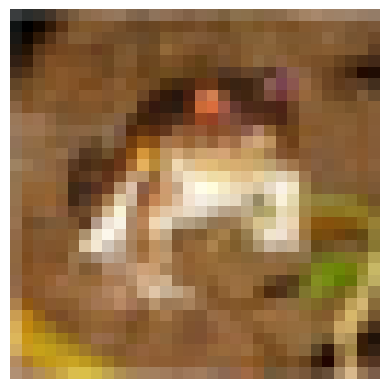

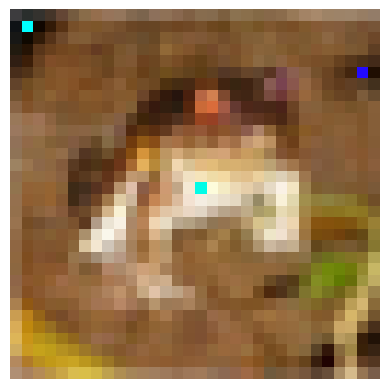

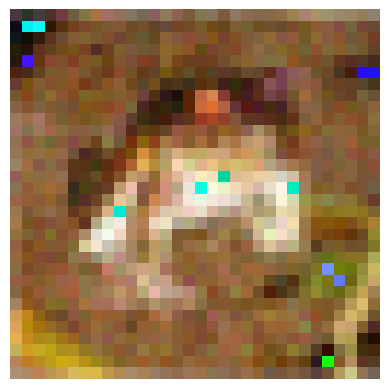

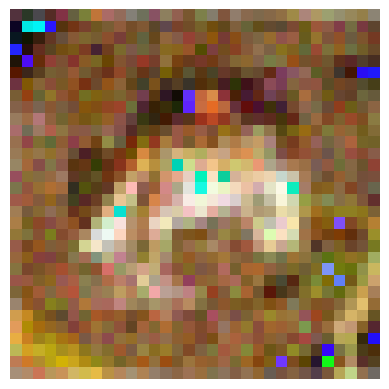

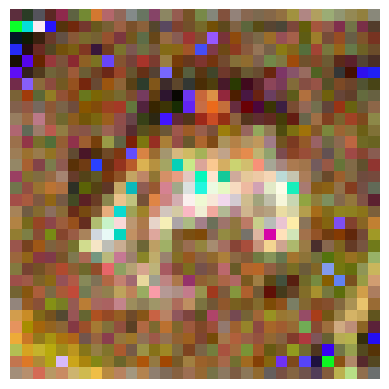

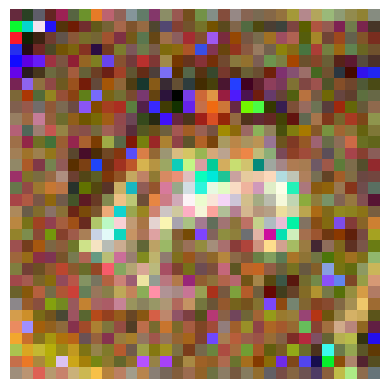

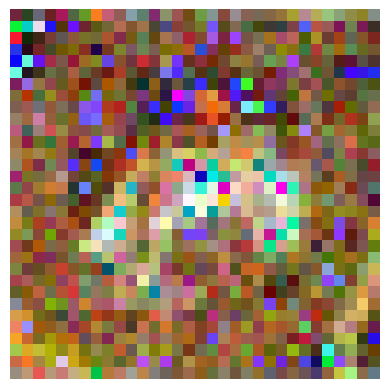

Test Sampling Function (untrained Model):


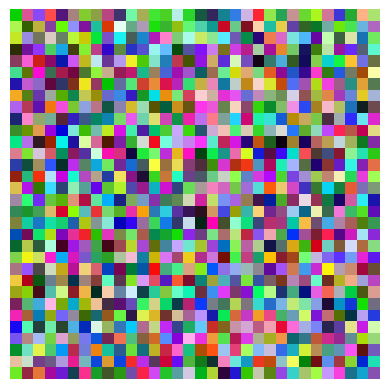

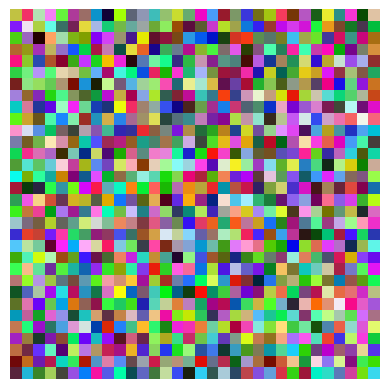

Test Intermediates Latents Sampling Function (untrained Model):


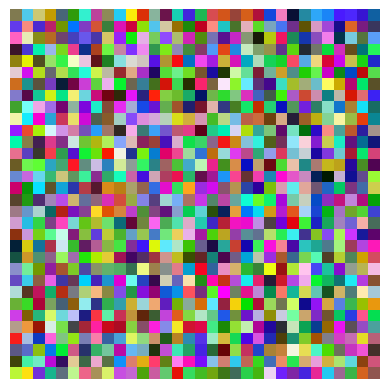

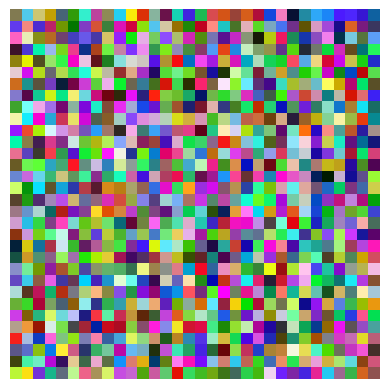

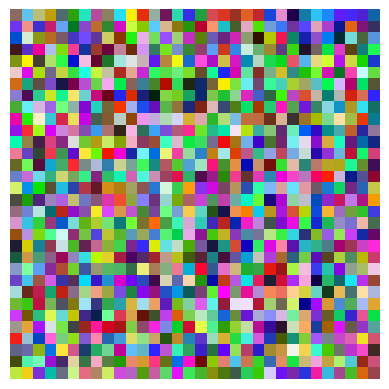

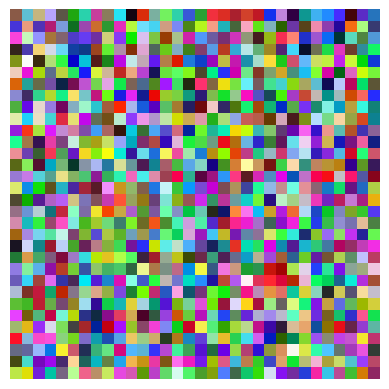

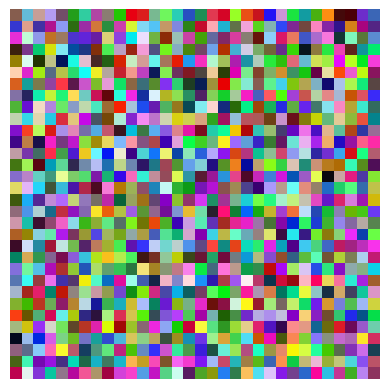

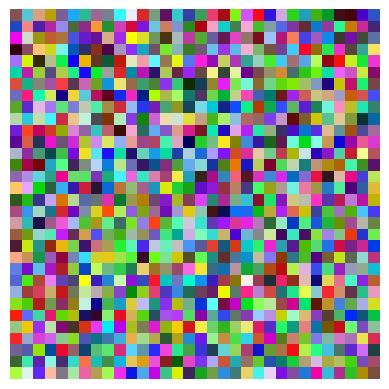

In [7]:
import matplotlib.pyplot as plt
import os

#### 
#Important! Since we are drawing images from these noise/denoising Gaussian distributions, 
#the color channels of the input images x_0 have to be normalized from the discrete range [0,255] to 
#the continuous range [-1,1].
####

# Plots the given image tensor
def show_image(tensor_image):
    # renormalize the tensor back from [-1,1] to interpretable color channels 
    transform = transforms.Compose([transforms.Normalize(mean=(-1,-1,-1),std=(2,2,2)),transforms.ToPILImage()])
    image = transform(tensor_image)
    plt.imshow(image)
    plt.axis('off')
    plt.show()
    
# load CIFAR-10
data_dir = '~/pytorch_datasets/CIFAR10'
dataset = datasets.CIFAR10(data_dir, download=True)

# performs normalization to [-1,1] for a given image
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# load first image of a toad
image,_ = dataset[0]
x_0 = transform(image)
  
# simple DM with 6 steps
c = 'cosine'
l = 'linear'
cb = 'cosine_bounded'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
dm = DDPM(noise_schedule=l, diffusion_steps=6, device = device)

# add noise along the forward trajectory
print('Add Noise:')
show_image(x_0)
_, forward_noise = dm.forward_trajectory(x_0)
for t in range(1, dm.diffusion_steps+1): # go through full forward trajectory
    x_t = dm.noised_latent(forward_noise, x_0, torch.tensor([t]))
    show_image(x_t.squeeze(0))

# generate a batch of samples
print('Test Sampling Function (untrained Model):')
samples = dm.sample(batch_size = 2)
for sample in samples:
    show_image(sample.squeeze(0))
    
# generate one sample with its full reverse trajectory noised latents
print('Test Intermediates Latents Sampling Function (untrained Model):')
samples = dm.sample_intermediates_latents()
for sample in samples:
    show_image(sample)
# Important! This diffusion model has been initialized without a neural backbone, hence
# the sampled images are all pure noise (for testing sampling functions)
# => See pipeline.ipynb notebook for some generated images from our trained model
#    (For efficiency, we usually generate big batches of our images on the HPC)

### Visual Comparison between Noise schedulers

Files already downloaded and verified


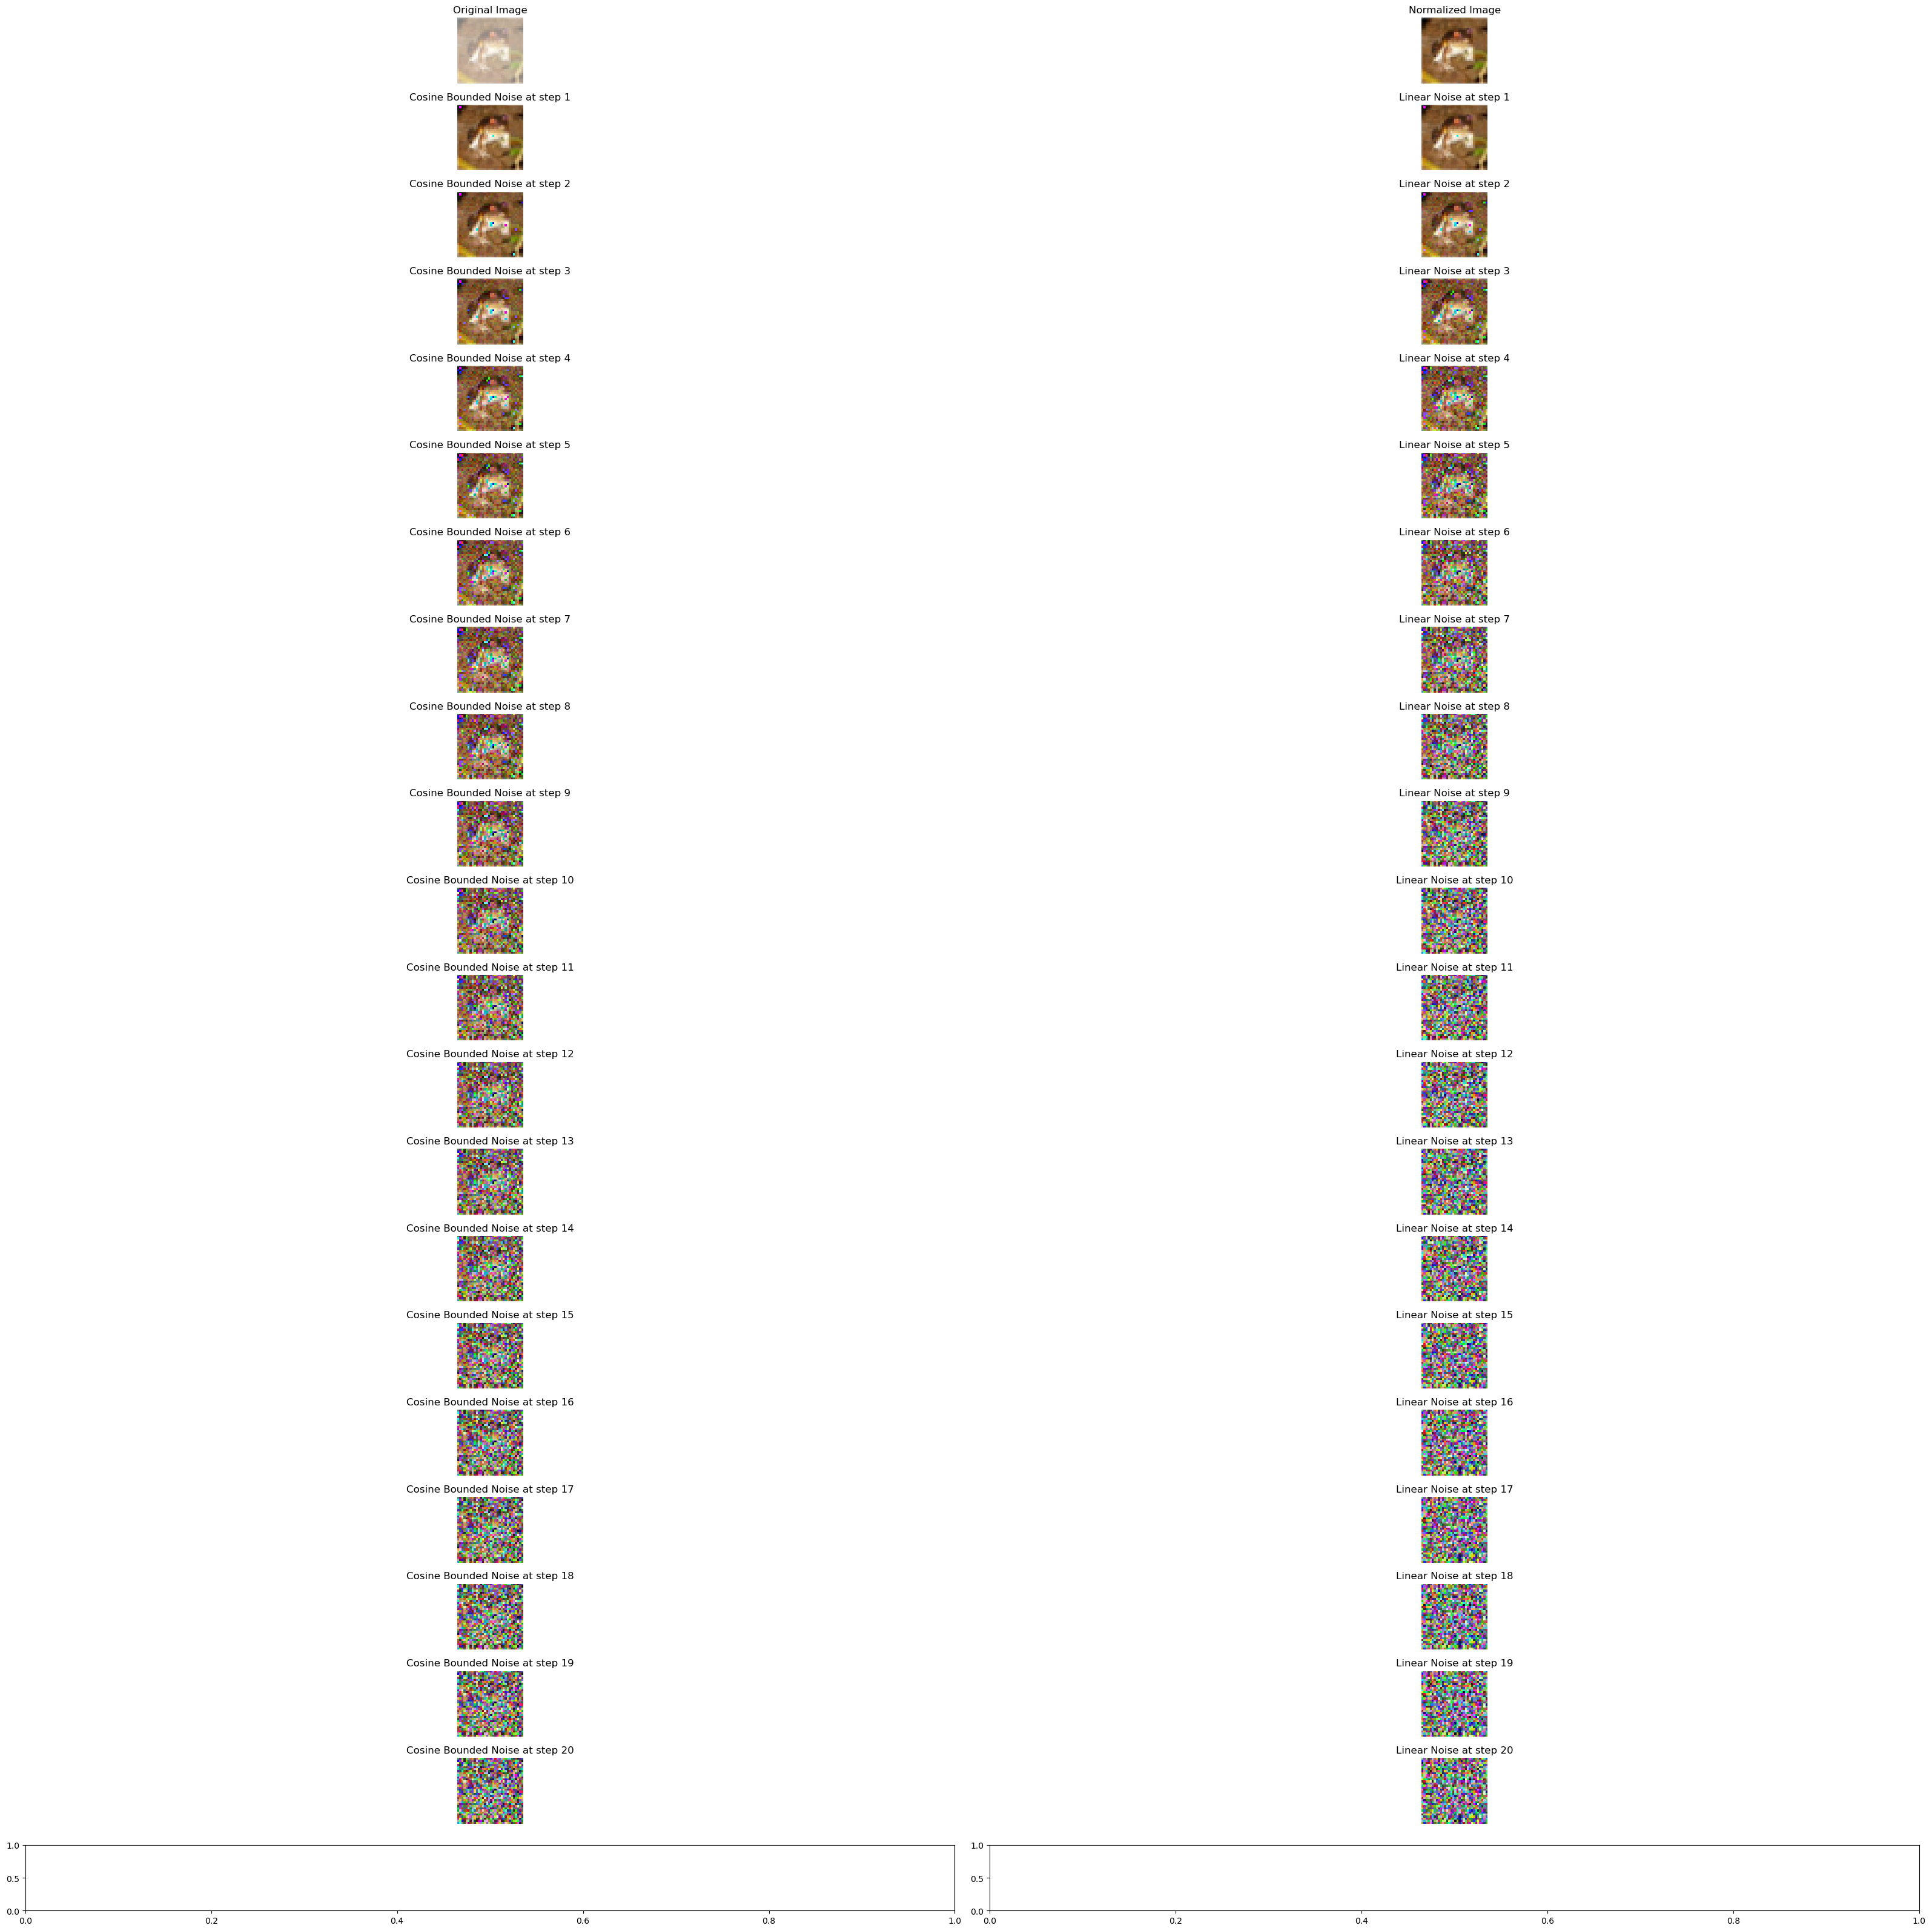

In [8]:
from torchvision import transforms

# Plots the given image tensor for multiple images
def show_images(axs, tensor_image):
    # renormalize the tensor back to from [-1,1] to interpretable color channels 
    transform = transforms.Compose([transforms.Normalize(mean=(-1,-1,-1),std=(2,2,2)),transforms.ToPILImage()])
    image = transform(tensor_image)
    axs.imshow(image)
    axs.axis('off')

# load CIFAR-10 image
data_dir = '~/pytorch_datasets/CIFAR10'
dataset = datasets.CIFAR10(data_dir, download=True)

# transforms
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

transform_tensor = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
])

image,_ = dataset[0]
x_0 = transform(image)
image = transform_tensor(image)
 
# simple DMs with 20 steps   
c = 'cosine'
cb = 'cosine_bounded'
l = 'linear'
dm_linear = DDPM(noise_schedule=l, beta_T = 0.2, diffusion_steps=20)
dm_cosine = DDPM(noise_schedule=cb, alpha_bar_lower_bound = 0.6, diffusion_steps=20)

# plot forward trajectories on the image
fig, axs = plt.subplots(dm_cosine.diffusion_steps+2, 2, figsize=(32, 32))
show_images(axs[0, 0], image)
axs[0, 0].set_title('Original Image')
show_images(axs[0, 1], x_0)
axs[0, 1].set_title('Normalized Image')

noise = torch.randn(x_0.shape) # eps param for the full forward chain
for i in range(1, dm_cosine.diffusion_steps+1): # go through all T noise adding dist.
    noised_cosine = dm_cosine.noised_latent(noise, x_0, t=torch.tensor([i]))
    noised_linear = dm_linear.noised_latent(noise, x_0, t=torch.tensor([i]))
    
    show_images(axs[i, 1], noised_linear.squeeze(0))
    axs[i, 1].set_title(f'Linear Noise at step {i}')
    show_images(axs[i, 0], noised_cosine.squeeze(0))
    axs[i, 0].set_title(f'Cosine Bounded Noise at step {i}')

plt.tight_layout()
plt.show()

### Analytical Comparison between Noise schedulers

Observe that for a **linear noise schedule from (0,1)**, after 20% of the diffusion steps are completed, we start adding significant amounts of noise to the input image. In these high-entropy states, the model has a hard time learning to distinguish patterns and structures from noise.

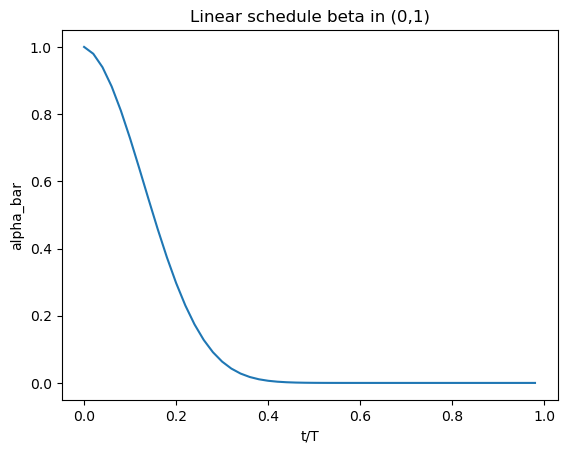

-------------------------------------------------------------------


In [9]:
####
# Recall that 1-alpha_bar is the varaince for the complete forward dist (adds noise).
####

beta = torch.linspace(0, 1, 50)
alpha = 1 - beta
alpha_bar = torch.cumprod(alpha, dim=0)
x = np.arange(0,50)  
y = alpha_bar 
plt.plot(x/50, y)  
plt.xlabel('t/T') 
plt.ylabel('alpha_bar')
plt.title('Linear schedule beta in (0,1)')
plt.show()
plt.plot(x/50, beta) 
plt.xlabel('t/T') 
plt.ylabel('beta')  
plt.title('Linear schedule beta in (0,1)')  
plt.show()
print('-------------------------------------------------------------------')

Thats why in practice Ho et. al suggested to only focus on variances between **(10ˆ-4, 0.02)**

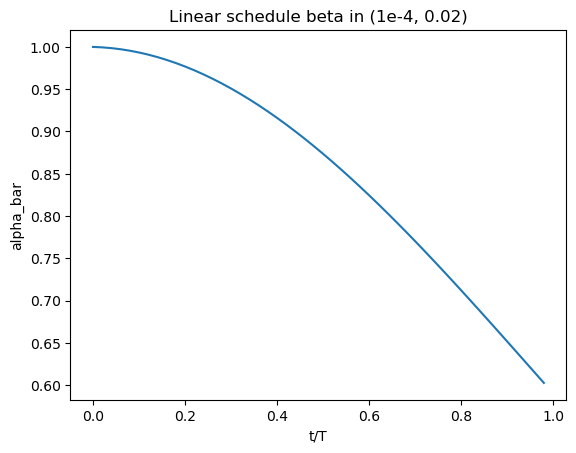

-------------------------------------------------------------------


In [10]:
beta = torch.linspace(1e-4, 0.02, 50)
alpha = 1 - beta
alpha_bar = torch.cumprod(alpha, dim=0)       
X = np.arange(0,50)  
y = alpha_bar  
plt.plot(x/50, y)  
plt.xlabel('t/T')  
plt.ylabel('alpha_bar')  
plt.title('Linear schedule beta in (1e-4, 0.02)')  
plt.show() 
plt.plot(x/50, beta) 
plt.xlabel('t/T') 
plt.ylabel('beta')  
plt.title('Linear schedule beta in (1e-4, 0.02)')  
plt.show()
print('-------------------------------------------------------------------')

Alternatively, in the **cosine noise schedule** from Nichol and Dhariwal, we have a gradual linear drop-off for beta values between **(0,1)**. However, using the full cosine schedule may not be optimal as it approaches variances near 1, which add too much noise too quickly. One possible solution is to bound the alpha_bar.

In [11]:
X = np.arange(0,50) 
dm = DDPM(noise_schedule='cosine')
plt.plot(x/50, dm.alpha_bar) 
plt.xlabel('t/T') 
plt.ylabel('alpha_bar')  
plt.title('Cosine schedule beta in (0,1)')  
plt.show() 
plt.plot(x/50, dm.beta) 
plt.xlabel('t/T') 
plt.ylabel('beta')  
plt.title('Cosine schedule beta in (0,1)')  
plt.show()
print('-------------------------------------------------------------------')

-------------------------------------------------------------------


This is our experimental version of a **bounded cosine schedule**. It still has a linear drop-off in $\bar{\alpha}$ while imposing a lower bound $\bar{\alpha}_T = \text{alpha_bar_lower_bound}$ to avoid reaching high variances that add excessive noise. However, it's important to note that this bounded cosine schedule is not sigmoidal, and the betas are no longer smooth.

In [12]:
dm = DDPM(noise_schedule='cosine_bounded')
beta = dm.beta
alpha_bar = dm.alpha_bar
plt.plot(x/50, alpha_bar) 
plt.xlabel('t/T') 
plt.ylabel('alpha_bar')  
plt.title('Bounded cosine schedule, alpha_bar in (0.9, 1)')  
plt.show()
plt.plot(x/50, beta) 
plt.xlabel('t/T') 
plt.ylabel('beta')  
plt.title('Bounded cosine schedule, alpha_bar in (0.9, 1)')  
plt.show()
print('-------------------------------------------------------------------')

-------------------------------------------------------------------


Another possible solution is to directly linearize $\bar{\alpha}$ instead, and recompute the betas and alphas from there. However, this approach presents a problem where the betas increase too much at the beginning, when they should start adding low amounts of noise and gradually increase.

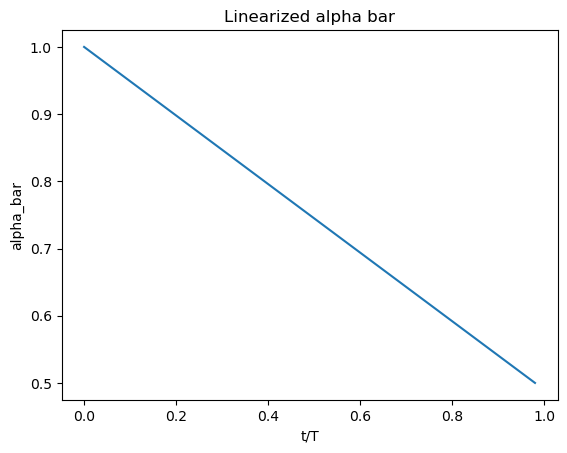

In [13]:
x = np.arange(0,50) 
alpha_bar_cap = 0.5
alpha_bar = torch.linspace(1, alpha_bar_cap, 50).tolist()
shift = [1] + alpha_bar[:-1]
shift = np.array(shift)
alpha_bar = np.array(alpha_bar)
beta = 1 - np.divide(alpha_bar,shift)
beta = np.clip(beta, a_min =None, a_max = 0.999) #suggested by paper "Improved Denoising Diffusion Probabilistic Models"
alpha = 1 - beta
plt.plot(x/50, alpha_bar) 
plt.xlabel('t/T') 
plt.ylabel('alpha_bar')  
plt.title('Linearized alpha bar')  
plt.show() 
plt.plot(x/50, beta) 
plt.xlabel('t/T') 
plt.ylabel('beta')  
plt.title('Linearized alpha bar')  
plt.show()

### Visualizing the loss MSE weight from the VLB

As a reminder, the MSE weights from the KL losses are given by:

$$L_{t} := \frac{\beta_t^2}{2\text{var}_t \alpha_t(1-\bar{\alpha}_t)} \big{\|} \epsilon - \epsilon_{\theta}(x_t, t) \big{\|}_{2}^2.$$

In this section, we analyze the behavior of the MSE weight along the reverse trajectory with respect to the **linear and cosine noise schedule** for the complete variance range beta in **(0,1)**. These results confirm our previous statements in the theory part above, that the MSE weights increase over time. During training, we consider the first denoising steps $t$ near $T$ to be much more important than the last steps near $0$. This may result in poor image reconstructions when sampling and an effort to overfit to the data when trying to separate the image and the forward noise from an image that is practically pure noise. By ignoring the MSE weight, we equally weight all denoising timestep losses $L_t$, thus acting as a form of regularization.<br/>
Furthermore, it's worth noting that the weights appear to be somewhat large, ranging between 0 to 25 and 500, respectively. These large weights may potentially impact the gradient descent step negatively. Moreover, the cosine schedule may cause further training instabilities, since the initial denoising step weights are several orders of magnitude greater than the remaining trajectory.

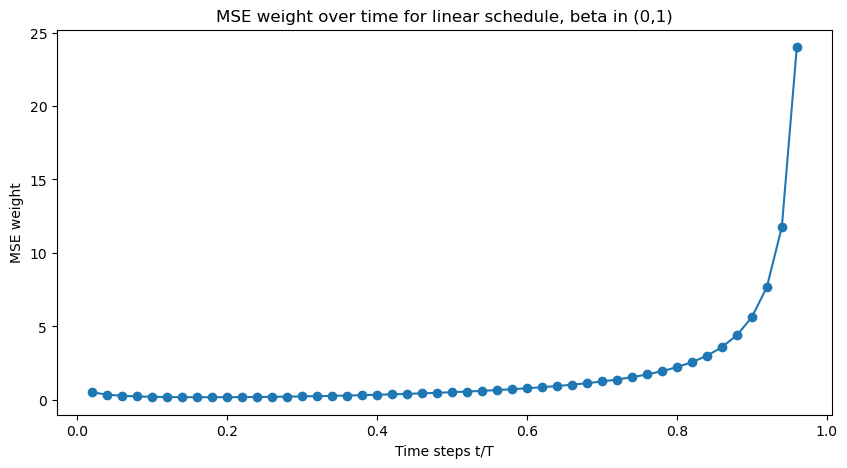

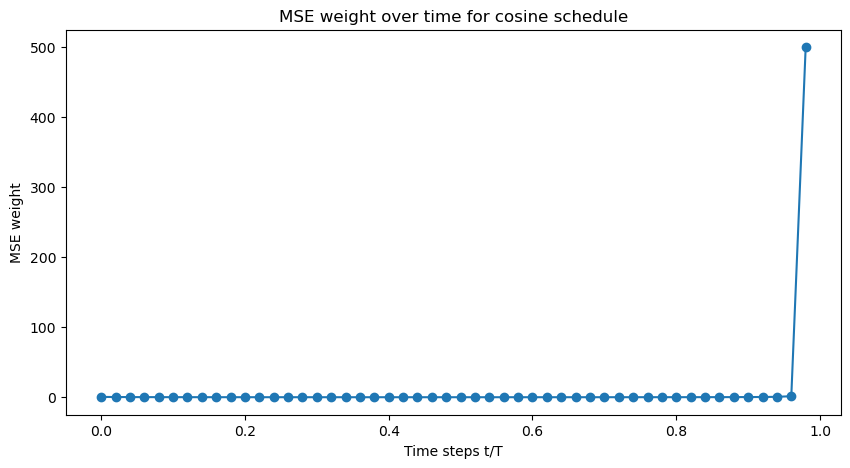

In [14]:
import matplotlib.pyplot as plt

####
# Recall that the reverse trajectory starts at timestep t=T (i.e. diffusion_steps) and is applied in reverse 
# order until t=0. Therefore, the rightmost weight on the plots refers to the first denoising steps.
####

# print weights
dm_lin_comp = DDPM(beta_1=0, beta_T =1)
plt.figure(figsize=(10,5))
plt.plot(np.arange(0,dm_lin_comp.diffusion_steps)/dm_lin_comp.diffusion_steps, dm_lin_comp.mse_weight, marker='o')
plt.xlabel('Time steps t/T')
plt.ylabel('MSE weight')
plt.title('MSE weight over time for linear schedule, beta in (0,1)')
plt.show()

dm_cos = DDPM(noise_schedule='cosine')
plt.figure(figsize=(10,5))
plt.plot(np.arange(0,dm_lin_comp.diffusion_steps)/dm_lin_comp.diffusion_steps, dm_cos.mse_weight, marker='o')
plt.xlabel('Time steps t/T')
plt.ylabel('MSE weight')
plt.title('MSE weight over time for cosine schedule')
plt.show()

Interestingly enough, when bounding the noise distribution variances beta, the relationship **inverts**, such that higher weights are associated with smaller timesteps and vice versa. Here, we plot the MSE against timesteps for the **bounded linear and cosine noise schedules**.

This inversion of the weight distribution might negatively impact the generative ability of the model. During training, the model focuses more on the accurate reconstruction of the training images near $t=0$. However, when sampling/generating new images, the model might struggle to properly denoise the starting image, which consists of pure noise, possibly limiting its ability to generate or reimagine new images.

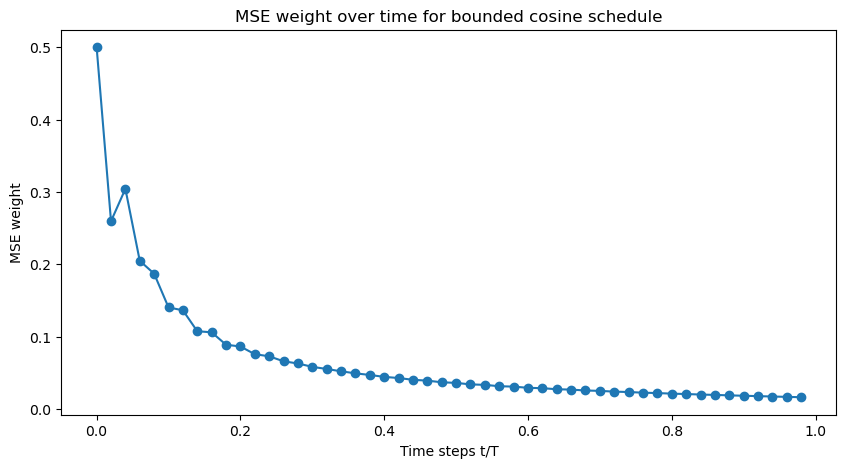

In [15]:
dm_lin = DDPM(noise_schedule='linear')
plt.figure(figsize=(10,5))
plt.plot(np.arange(0,dm_lin_comp.diffusion_steps)/dm_lin_comp.diffusion_steps, dm_lin.mse_weight, marker='o')
plt.xlabel('Time steps t/T')
plt.ylabel('MSE weight')
plt.title('MSE weight over time for linear schedule beta in (1e-4,0.02)')
plt.show()

dm_cos_b = DDPM(noise_schedule='cosine_bounded')
plt.figure(figsize=(10,5))
plt.plot(np.arange(0,dm_lin_comp.diffusion_steps)/dm_lin_comp.diffusion_steps, dm_cos_b.mse_weight, marker='o')
plt.xlabel('Time steps t/T')
plt.ylabel('MSE weight')
plt.title('MSE weight over time for bounded cosine schedule')
plt.show()

To avoid potential instabilities caused by the MSE weights, as is commonly done in practice, we generally choose to ignore it during training by using the simplified KL loss, i.e. setting **kl_loss='simplified'**. This simplification helps to mitigate the overemphasis on the early denoising steps and reduces the risk of the model overfitting to the training images. By ignoring the MSE weights, the training process becomes more stable, allowing for better generalization and improved generative abilities when sampling or generating new images.
<br/><br/>
It's important to note that these conclusions have been reached through our analysis, and they should be taken as observations based on our specific experimentation and analysis, rather than definitive facts or proofs.